In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Preprocess Data

In [112]:
df = pd.read_csv("data/training_data.csv")
scaler = StandardScaler()
feature_columns = ["pressure", "air_temp", "ground_temp", "velocity_x", "velocity_y"]
df[feature_columns] = scaler.fit_transform(df[feature_columns])
# don't normalize windspeed
feature_columns.append("windspeed")
df.head()

,hour,day,hour_of_day,city,pressure,air_temp,ground_temp,velocity_x,velocity_y,windspeed,damage
0,1,1,0,Tensorburg,-0.072944,-0.046722,0.766478,0.390384,-0.178316,0.0743,0.2870
1,1,1,0,Sparseville,-0.106134,-0.116896,-0.925940,-0.368484,-0.247732,0.1329,0.5212
2,1,1,0,Offshore B,-0.045936,-0.081809,-0.248973,-0.132795,0.211482,0.1144,0.4280
3,1,1,0,ReLU Ridge,-0.032269,0.023452,1.477293,-0.430644,-0.030585,0.1366,0.5430
4,1,1,0,GANopolis,-0.081729,-0.116896,-0.655153,0.486214,-0.219254,0.0678,0.2692


## Create Database

In [ ]:
# Split the data into 5 day windows
def create_windows(df_city, input_window, output_window, feature_columns, target_column):
    X, y = [], []
    total_steps = input_window + output_window
    for i in range(len(df_city) - total_steps + 1):
        window = df_city.iloc[i: i + total_steps]
        # Input: features for the input window
        X_window = window.iloc[:input_window][feature_columns].values
        # Target: windspeed for the following output window
        y_window = window.iloc[input_window:][target_column].values
        X.append(X_window)
        y.append(y_window)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [ ]:
# split into seperate city data
X_list, y_list = [],[]
for city, df_city in df.groupby('city'):
    df_city = df_city.reset_index(drop=True)
    X_city, y_city = create_windows(df_city, 
                                    120, # 5 days input
                                    120, # 5 days output
                                    feature_columns, "windspeed")
    X_list.append(X_city)
    y_list.append(y_city)

# Combine windows from all cities
X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)

In [ ]:
# pytorch dataset for selecting indices
class WindSpeedDataset(Dataset):
    def __init__(self, X, y, city=None):
        self.X = X
        self.y = y
        self.city = city
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


## Model

In [ ]:
# Simple LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_window):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Map the last hidden state to the output window
        self.fc = nn.Linear(hidden_size, output_window)
        
    def forward(self, x):
        # x: (batch, sequence_length, input_size)
        batch_size = x.size(0)
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        # Use the last layer's hidden state of the final time step
        last_hidden = hn[-1]  # shape: (batch, hidden_size)
        prediction = self.fc(last_hidden)  # shape: (batch, output_window)
        return prediction

## Training

In [141]:
# Split the data into training and test sets
X_tensor = torch.tensor(X_all, dtype=torch.float32)
y_tensor = torch.tensor(y_all, dtype=torch.float32)
n = int(X_tensor.shape[0] * 0.8)
X_train = X_tensor[:n]
X_test = X_tensor[n:]
Y_train = y_tensor[:n]
Y_test = y_tensor[n:]
train_dataset = WindSpeedDataset(X_train, Y_train)
test_dataset = WindSpeedDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [142]:
# For the final run, train on all data
dataset = WindSpeedDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [143]:
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 0.001
model = LSTMModel(6, 128, 3, 120).to(device) # 6 features, 128 hidden units, 3 layers, 120 output hours
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
# training with validation
import time
writer = SummaryWriter(log_dir = f"runs/{time.time()}")
for epoch in range(50): # 50 epochs
    model.train()
    total_train_loss = 0.0
    train_samples = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)    # shape: (batch, input_window, input_size)
        targets = targets.to(device)  # shape: (batch, output_window)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        batch_size_current = inputs.size(0)
        total_train_loss += loss.item() * batch_size_current
        train_samples += batch_size_current
    
    # Compute average training metrics
    avg_train_loss = total_train_loss / train_samples

    # Evaluate on validation set
    model.eval()
    total_val_loss = 0.0
    val_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_size_current = inputs.size(0)
            total_val_loss += loss.item() * batch_size_current
            val_samples += batch_size_current

    avg_val_loss = total_val_loss / val_samples

    # Log metrics to TensorBoard
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)

writer.close()

In [144]:
# training with validation
import time
writer = SummaryWriter(log_dir = f"runs/{time.time()}")
for epoch in range(50): # 50 epochs
    model.train()
    total_train_loss = 0.0
    train_samples = 0

    for inputs, targets in data_loader:
        inputs = inputs.to(device)    # shape: (batch, input_window, input_size)
        targets = targets.to(device)  # shape: (batch, output_window)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        batch_size_current = inputs.size(0)
        total_train_loss += loss.item() * batch_size_current
        train_samples += batch_size_current
    
    # Compute average training metrics
    avg_train_loss = total_train_loss / train_samples

    # Log metrics to TensorBoard
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)

writer.close()

## Validation and submission

51


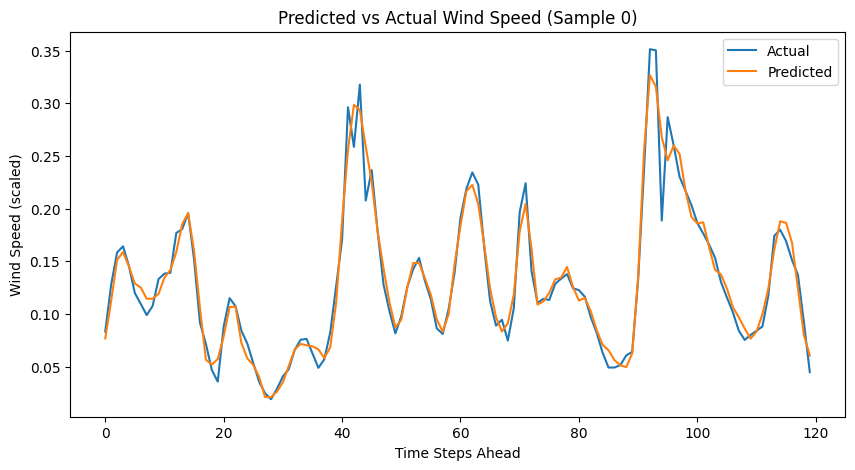

In [ ]:
model.eval()
load = iter(test_loader)
print(len(load))
# skip ahead n batches to look at a sample
for i in range(35):
    inputs, targets = next(load)
inputs, targets = inputs.to(device), targets.to(device)

with torch.no_grad():
    preds = model(inputs)

# Convert back to CPU / NumPy if needed
preds = preds.cpu().numpy()
targets = targets.cpu().numpy()

# Plot the first sample in the batch
plt.figure(figsize=(10,5))
plt.plot(targets[0], label='Actual')
plt.plot(preds[0], label='Predicted')
plt.title("Predicted vs Actual Wind Speed (Sample 0)")
plt.xlabel("Time Steps Ahead")
plt.ylabel("Wind Speed (scaled)")
plt.legend()
plt.show()

# note, this picture below comes after we trained on all data, not just the training set

In [ ]:
from sklearn.metrics import r2_score
# This was tested before training on all data, so the output is a valid R^2 score
model.eval()  

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)  
        
        preds_np = outputs.cpu().numpy()
        targets_np = targets.cpu().numpy()
        
        all_preds.append(preds_np)
        all_targets.append(targets_np)

all_preds = np.concatenate(all_preds, axis=0)     # shape: [num_samples, output_window]
all_targets = np.concatenate(all_targets, axis=0) # shape: [num_samples, output_window]

r2_flat = r2_score(all_targets.flatten(), all_preds.flatten())
print("R² (flattened across all timesteps):", r2_flat)

r2_per_step = []
for step in range(all_preds.shape[1]):
    r2_step = r2_score(all_targets[:, step], all_preds[:, step])
    r2_per_step.append(r2_step)

print("R² per forecast step:", r2_per_step)


R² (flattened across all timesteps): 0.38546502590179443
R² per forecast step: [0.4276053309440613, 0.4491801857948303, 0.4546428322792053, 0.45725345611572266, 0.43825268745422363, 0.4437575936317444, 0.44374287128448486, 0.4430497884750366, 0.44200319051742554, 0.43568503856658936, 0.44962847232818604, 0.441287636756897, 0.44359344244003296, 0.43693017959594727, 0.426926851272583, 0.4232082962989807, 0.43540793657302856, 0.4192148447036743, 0.4328792691230774, 0.42889147996902466, 0.41902732849121094, 0.42023658752441406, 0.4123010039329529, 0.40961557626724243, 0.40778517723083496, 0.41042327880859375, 0.41081100702285767, 0.40360838174819946, 0.4080498218536377, 0.42672067880630493, 0.4157068729400635, 0.4233638048171997, 0.4167367219924927, 0.4176952838897705, 0.42647355794906616, 0.41910815238952637, 0.42918825149536133, 0.41884177923202515, 0.42421579360961914, 0.41999906301498413, 0.4255554676055908, 0.4170967936515808, 0.4256772994995117, 0.4195265769958496, 0.4150605201721191

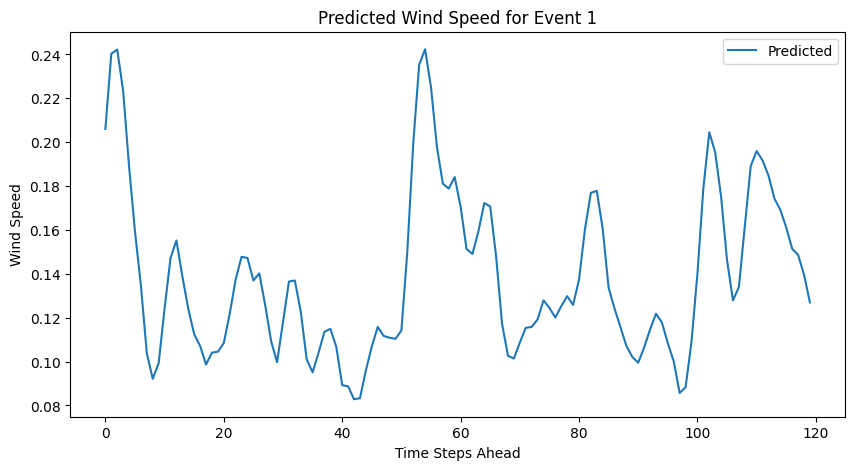

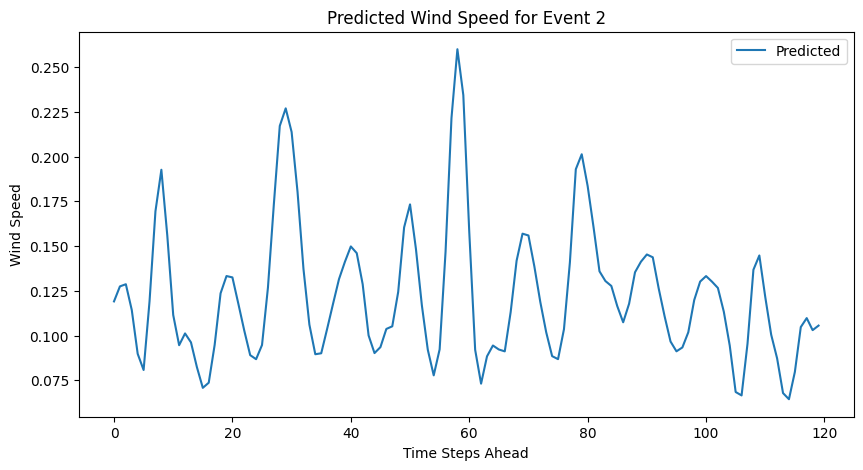

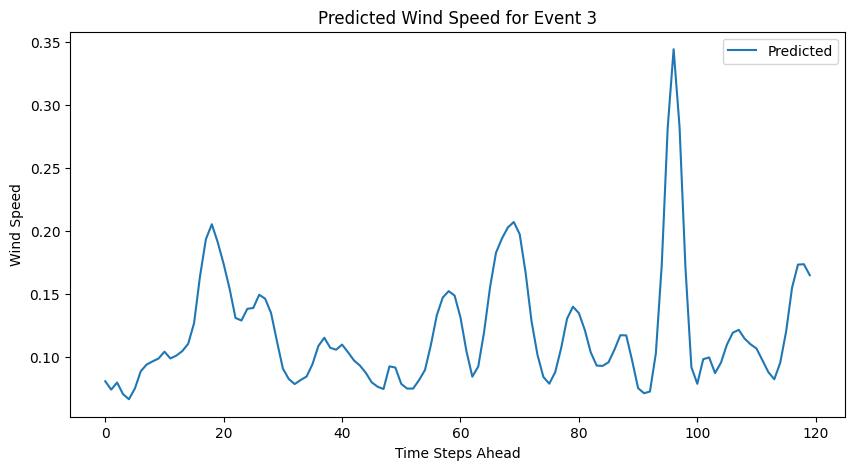

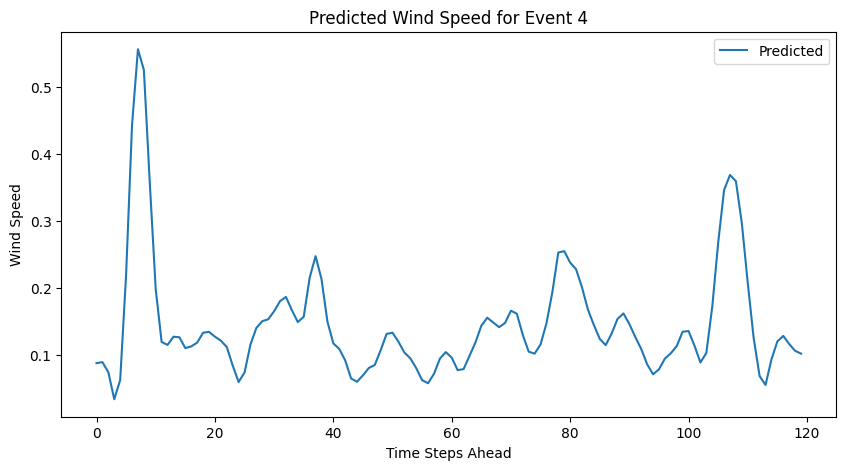

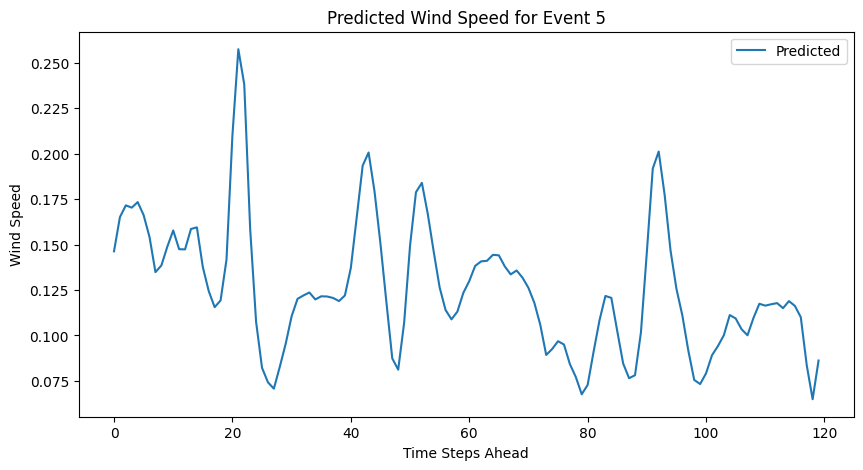

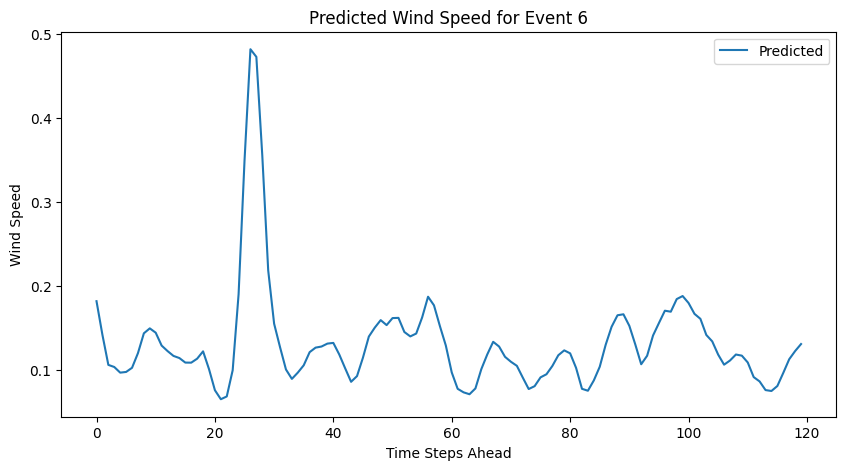

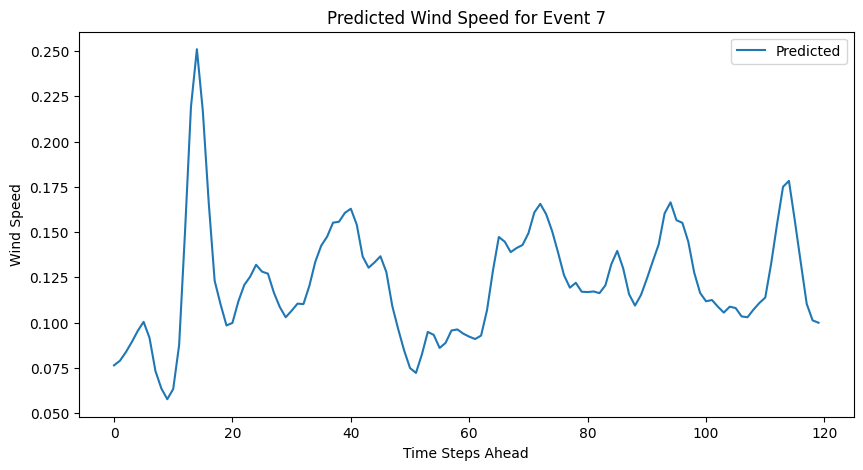

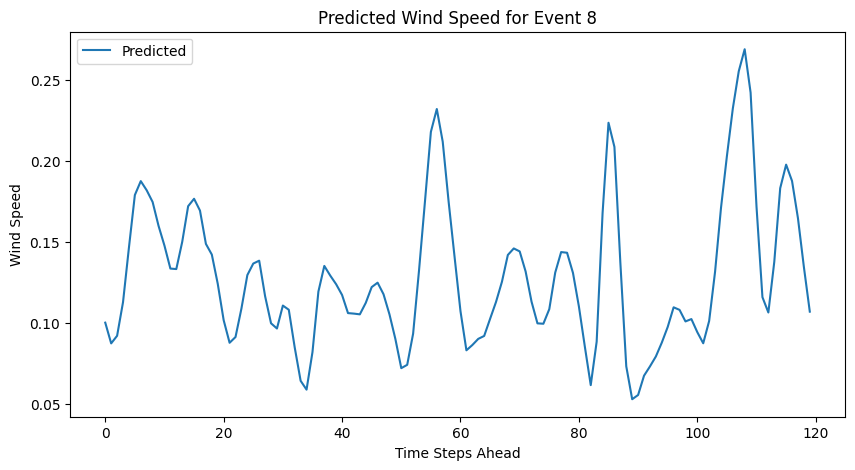

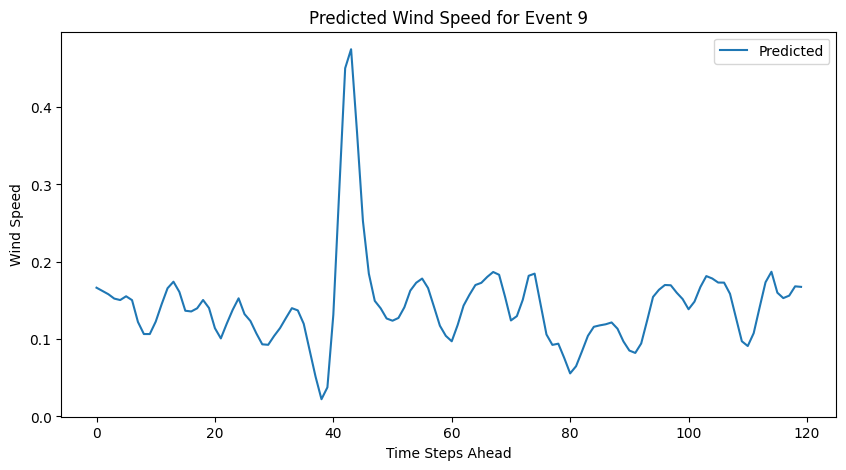

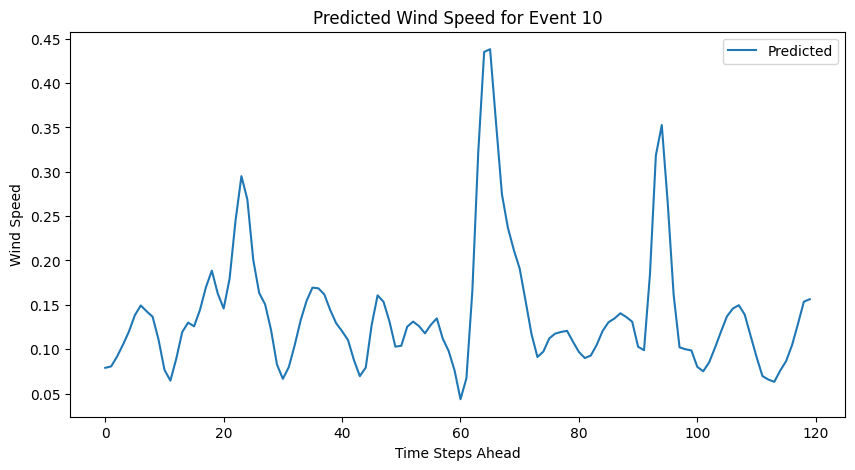

In [161]:
sub = pd.read_csv("submission/submission.csv")

for i in range(1, 11):

    # load each event's data, then extract the city's data
    df = pd.read_csv(f"data/event_{i}.csv")
    gdf = df[df["city"] == "GANopolis"].copy()
    normalized_features = ["pressure", "air_temp", "ground_temp", "velocity_x", "velocity_y"]
    gdf[normalized_features] = scaler.transform(gdf[normalized_features])
    X = torch.tensor(gdf[feature_columns].values, dtype=torch.float32).unsqueeze(0).to(device)
    
    # get the predictions, then write them to the submission file
    with torch.no_grad():
        preds = model(X)
    preds = preds.squeeze(0).cpu().numpy()
    for col_idx in range(120):
        sub.loc[sub["event_number"] == i, str(col_idx)] = preds[col_idx]

    # plot predictions for 10 events
    plt.figure(figsize=(10, 5))
    plt.plot(preds, label='Predicted')
    plt.title(f"Predicted Wind Speed for Event {i}")
    plt.xlabel("Time Steps Ahead")
    plt.ylabel("Wind Speed")
    plt.legend()
    plt.show()

In [ ]:
damage_sums = []  # Will hold total damage for each of the 10 events
for i in range(1, 11):
    # Locate the row for the current event i
    row_mask = sub["event_number"] == i
    row = sub.loc[row_mask]
    
    # Extract wind speeds from columns "0" through "119"
    # row.loc[:, "0":"119"] -> shape (1, 120) if there's exactly 1 row
    wind_speeds = row.loc[:, "0":"119"].values.flatten()  # shape (120,)

    # Compute damage for each wind speed, then sum
    total_damage = 0.0
    for ws in wind_speeds:
        if ws <= 0.4:
            damage = -0.9 + 12.04 * ws
        elif ws <= 0.5:
            damage = -184.75 + 463.51 * ws # these numbers were calculated from the R scripts
        else:
            damage = -2778.36 + 5411.92 * ws
        
        total_damage += float(damage)
    
    damage_sums.append(total_damage)

print("Total damage per event:", damage_sums)

Total damage per event: [92.27908106565468, 69.25838487088676, 64.24837093561875, 412.8262362553177, 73.53239734798665, 144.95233537733552, 68.6769367685913, 77.62533810421817, 149.88864814981812, 120.55856196790923]


In [ ]:
# update submission file with updated csv
for i, damage in enumerate(damage_sums):
    price1 = 250 + 0.5 * damage
    sub.loc[i, "price"] = price1
sub.to_csv("submission/sub.csv", index=False)